# Fitting Overtones in GW150914

_NOTE:_ this example is inteneded to demonstrate the functionality of the `ringdown` package using GW150914 as an example; it is not meant to reproduce the result from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract): we use a more general polarization model, assume different priors, and apply slightly different data conditioning; therefore, the results should not be expected to be identical Isi et al (2019).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pylab import *

import arviz as az
import numpyro
import pandas as pd
import seaborn as sns

import ringdown

sns.set_context('notebook')
sns.set_palette('colorblind')

numpyro.set_host_device_count(4)

## Data

Let's download the data for GW150914, found [here](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/).  We grab 32s of data in each IFO, sampled at 16 kHz.

In [3]:
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

If you grab the data, the MD5 sums should be:
```
MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853
```

In [4]:
!openssl md5 H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853


Now we make timeseries data objects out of the stored data:

In [5]:
h_raw_strain = ringdown.Data.read('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', ifo='H1', kind='GWOSC')
l_raw_strain = ringdown.Data.read('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', ifo='L1', kind='GWOSC')

Just a sanity-check plot of the raw strain (just look at the huuuuuge DC noise in LIGO):

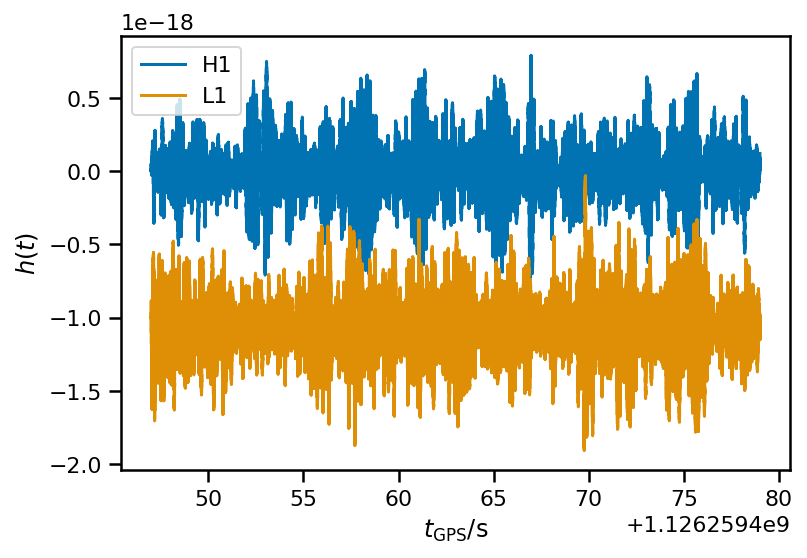

In [6]:
h_raw_strain.plot(label=h_raw_strain.ifo)
l_raw_strain.plot(label=l_raw_strain.ifo)
xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
ylabel(r'$h(t)$');
legend(loc='best');

Now that we've got the strain loaded up, we want to condition it a bit.  LIGO does not have very good high-frequency sensitivity; also, our modes do not have a lot of high-frequency content.  Additionally, LIGO contains a lot of low-frequency noise and our templates do not have a lot of power at low frequencies.  Here are estimated noise PSDs for our data:

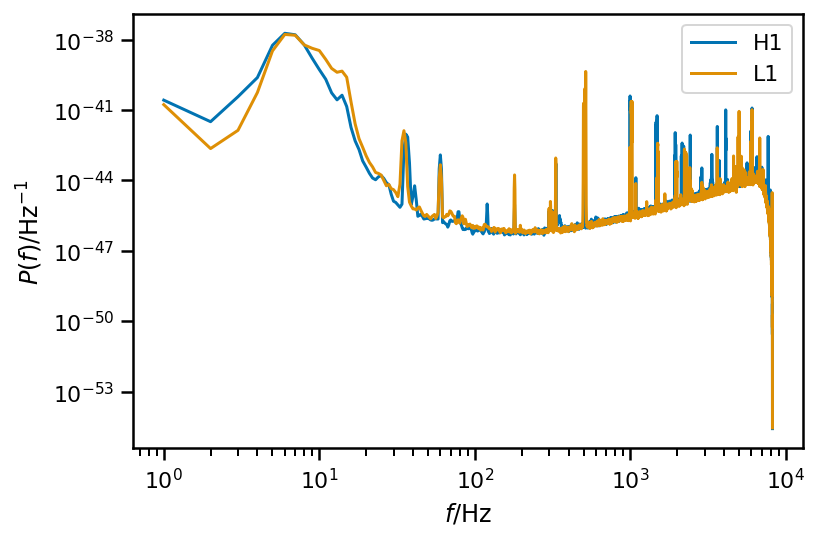

In [7]:
h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp)).iloc[1:].plot(label=h_raw_strain.ifo)
l_raw_strain.get_psd(nperseg=int(l_raw_strain.fsamp)).iloc[1:].plot(label=l_raw_strain.ifo)
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
xscale('log');
yscale('log');
legend(loc='best');

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a very short data segment (to eliminate low frequency content).  The `condition_data` method below accomplishes this; anticipating that we will only be analyzing the first two tones of the $(p = 1, s = -2, \ell = 2, m = 2)$ series of modes (prograde, spin-weight 2, angular quantum numbers $(2,2)$ modes), we will downsample to a sample rate of 4096 Hz, and a segment length of $\sim 40\, \mathrm{ms}$.  This is adequate to capture both the decay rate of the second tone (~700 Hz), and also the length of the first tone (time constant ~ 4.3 ms).  Generally, sampling at 2 to 4 times the decay rate of the highest overtone is sufficient to capture its decay smoothly (see plot below); above 1 or 2 kHz there is also so much noise in the LIGO interferometers that there is very little chance to measure anything at these frequencies.

You can see below that we choose a segment length that is ten times the estimated decay rate of the fundamental mode and a sampling frequency that is at least 4 times the decay rate of the first (highest) overtone. The choice of sampling rate is conservative for most analyses; however, the seglen is quite aggressive, since the noise whitening filter has a characteristic duration of ${\sim} 0.1\, \mathrm{s}$---for better (albeit slower) results, we could extend the analysis duration to ${\sim}0.2\, \mathrm{s}$.

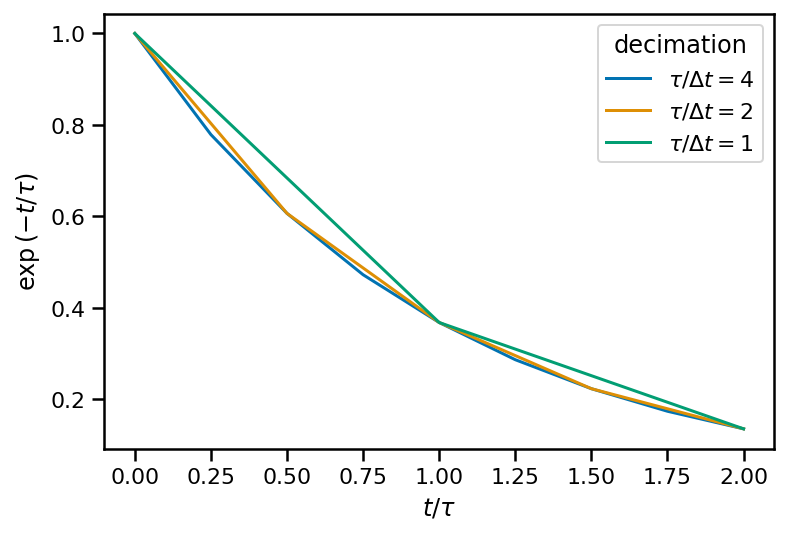

In [8]:
x = linspace(0, 2, 9)
for i in [1, 2, 4]:
    plot(x[::i], exp(-x[::i]), label=r'$\tau / \Delta t = {:.0f}$'.format(4/i))
legend(title='decimation')
xlabel(r'$t / \tau$')
ylabel(r'$\exp\left( - t / \tau \right)$');

In [9]:
M_est = 70.0
chi_est = 0.7

longest_tau = ringdown.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/ringdown.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

def next_pow_two(x):
    y = 1
    while y < x:
        y = y << 1
    return y

T = 10*longest_tau
srate = next_pow_two(2*highest_drate)

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 42.7 ms at sample rate 2048


When we downsample, we want to be sure to preserve a sample as close as possible to the ringdown "start time," corresponding to the arrival time of the peak of the complex strain of the (2,2) mode ([Giesler, et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhRvX...9d1060G/abstract)).  One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.  We take the sky location, polarization, and time of arrival from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), set the desired duration and sample rate, and call `condition_data`.  We high-pass filter the data with rollon at $20 \, \mathrm{Hz}$ to eliminate the large low-frequency noise present in the data.

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  (The modes are elliptically polarized, so there is no need to specify both + and - `m` quantum numbers; it is assumed that both positive and negative `m` contribute to a mode.)  Because Isi, et al. (2019) found only convincing evidence of two tones, that is the model we fit in this example.

In [11]:
fit = ringdown.fit.Fit(model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])  # use model='ftau' to fit damped sinusoids instead of +/x polarized GW modes
fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=1/T)

It is instructive to look at the whitened data segment in both interferometers:

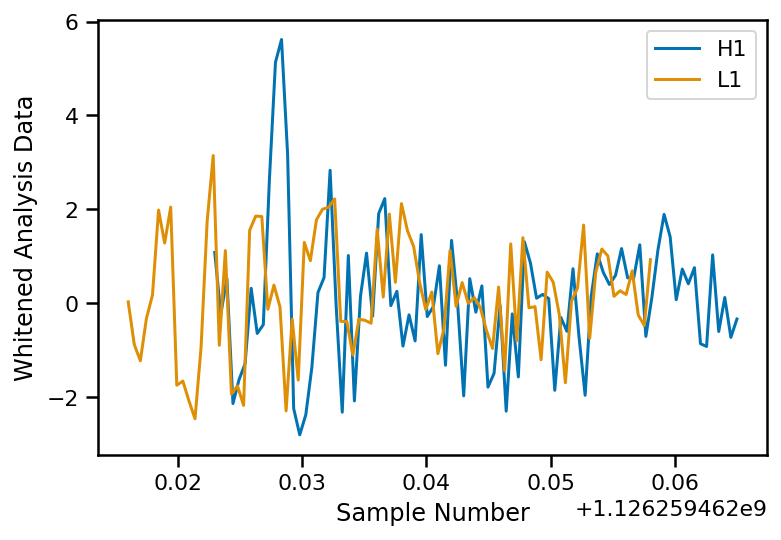

In [12]:
fit.compute_acfs()
wd = fit.whiten(fit.analysis_data)
plot(wd['H1'], label='H1')
plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

We can verify that our choice of segment length is reasonable (though not particularly conservative) by examining how the SNR accumulates with time in a whitened waveform.  We compute the (fractional) cumulative SNR in the fundamental, overtone, and a combination with an amplitude and phase that is close to how these modes combine in the actual waveform:
$$
S^2(t) = \frac{\int_{0}^t \mathrm{d} s \, \rho^2(s)}{\int_0^T \mathrm{d} s \, \rho^2(s)}.
$$

Overall, the SNR is around $13$ in the ringdown of GW150914, implying a fractional *statistical* uncertainty of $\sim \frac{2}{15}$ in the squared SNR; as long as our segement is long enough that the missing fraction of SNR relative to an infinite analysis segment is smaller than $\frac{2}{15}$, we have accumulated enough SNR to be statistically equivalent to an infinite analysis segment.

We test this by forming a sequence of times that is twice as long as our chosen analysis segement, calculating the accumulated fractional SNR for the fundamental, the overtone, and an out-of-phase combination of the overtone and fundamental that approximates how these modes appear in the real waveform.  The actual analysis segment is marked by the vertical black line in the figure below; the fractional "limit" of $1 - 1/15$ is marked by the horizontal line.  As you can see, by the end of our analysis segment, both the individual modes and the combined waveform have accumulated enough SNR that the remaining fraction is smaller than $2/15$, but the safety margin is not large.  **In a real analysis, we should probably use at least $T = 0.1 \, \mathrm{s}$**.  ([Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract) used $T = 0.2 \, \mathrm{s}$.)

An interesting aside: it is actually *the overtone* that accumulates SNR more slowly than the fundamental; presumably this is because it is a much broader signal in the frequency domain (much lower $Q$), and therefore interacts with more long-coherence-time lines in the whitening filter, and therefore gets whitened to longer timescale.

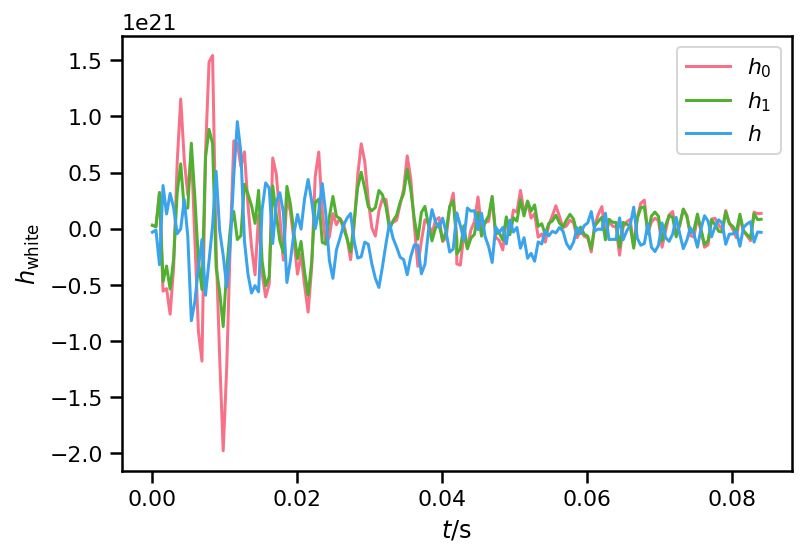

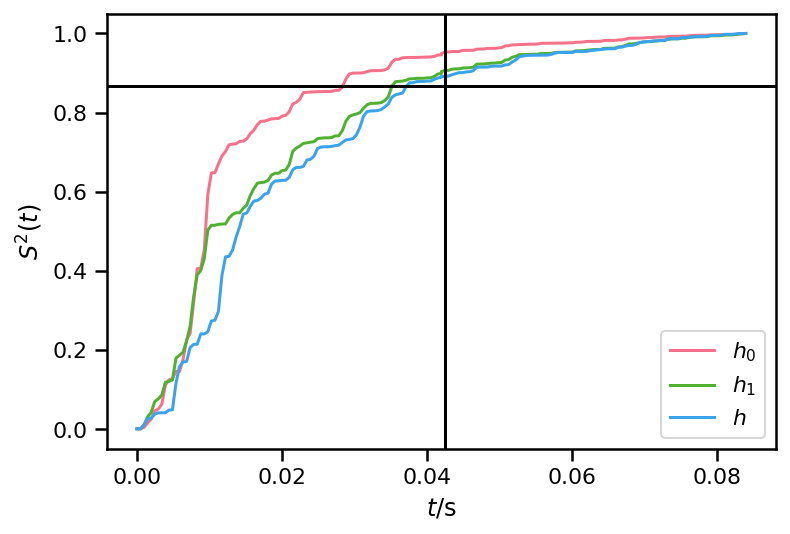

In [13]:
f0, tau0 = ringdown.qnms.get_ftau(M_est, chi_est, 0)
f1, tau1 = ringdown.qnms.get_ftau(M_est, chi_est, 1)

ts = fit.analysis_data['L1'].time
ts = ts-ts[0]
ts = ts.append(ts[-1]+ts)

wfs = {}

k0 = r'$h_0$'
k1 = r'$h_1$'
k2 = r'$h$'

wfs[k0] = exp(-ts/tau0)*cos(2*pi*f0*ts)
wfs[k1] = exp(-ts/tau1)*cos(2*pi*f1*ts)
wfs[k2] = wfs[k0] - 2*wfs[k1] # Approximate phase and amplitude relationship in the actual waveform...

# We will whiten with Livingston data
white_wfs = {k: fit.acfs['L1'].whiten(h) for k,h in wfs.items()}

with sns.color_palette('husl', n_colors=3):
    for k,v in white_wfs.items():
        plot(ts, v, label=k)
    legend()
    xlabel(r'$t / \mathrm{s}$')
    ylabel(r'$h_\mathrm{white}$')
    
figure()
cum_snrs = {k: cumsum(np.square(v))/sum(np.square(v)) for k,v in white_wfs.items()}
with sns.color_palette('husl', n_colors=3):
    for k,v in cum_snrs.items():
        plot(ts, v, label=k)
    legend()
    xlabel(r'$t/\mathrm{s}$')
    ylabel(r'$S^2(t)$')
    axvline(fit.n_analyze/fit.data['L1'].fsamp, color='k')
    axhline(1-2/15, color='k')

Just for a sanity check, let's look at the time of arrival of the peak strain in each IFO (Isi, et al. (2019) actually gives the `H1` start time, not the geocentre time, as `1126259462.423`):

In [14]:
fit.start_times

{'H1': 1126259462.423, 'L1': 1126259462.4160156}

Here you can see that the PSD of the conditioned data only goes up to 2048 Hz (it's been downsampled to a new Nyquist frequency of 2048 Hz), and that the noise power is much smaller below 20 Hz where we have filtered it.  The vertical black line marks the frequency that corresponds to $1/T$, aka the "first Fourier" bin for our short segment.

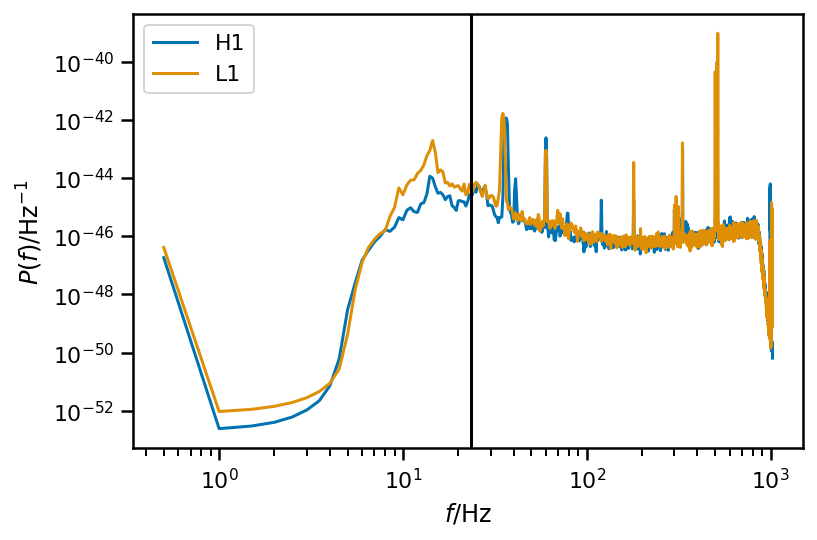

In [15]:
fit.data['H1'].get_psd(nperseg=4096).iloc[1:].plot(label='H1')
fit.data['L1'].get_psd(nperseg=4096).iloc[1:].plot(label='L1')
xscale('log');
yscale('log');
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P(f) / \mathrm{Hz}^{-1}$');
axvline(1/T, color='black');
legend(loc='best');

## Kerr fit

Before sampling over the posterior on modes, we need to set up some priors with reasonable choices:

In [16]:
print(fit.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max', 'flat_A', 'flat_A_ellip']


The `flat_A` and `flat_A_ellip` options control whether we place a Gaussian prior on the quadratures (`flat_A = flat_A_ellip = 0`)---which is the fastest to sample because it does not have weird linear structures in the quadratures---or a flat prior on the amplitude and isotropic in quadrature space (`flat_A > 0`, `flat_A_ellip=0`)---which samples almost as fast but can be useful to assess the presence of a mode, or (as in our paper) a flat prior on `A` and `ellip` (`flat_A = 0`, `flat_A_ellip > 0`).  We set `A_scale = 2e-21`, which controls the scale of the Gaussian prior (when `flat_A = flat_A_ellip = 0`) and also lets the sampler see approximately unit-scale variables (both prior choices).  Here we choose `flat_A = 1`.

In [17]:
fit.update_prior(A_scale=2e-21, M_min=35.0, M_max=140.0, flat_A=1)

Here are the priors (with default values for the options we didn't set).  The `perturb` are boolean arrays indicating whether to perturb `f` and `tau` around the GR values; the perturbations (if present) are bounded to a maximum amplitude.

In [18]:
fit.prior_settings

{'A_scale': 2e-21,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A': 1,
 'flat_A_ellip': 0}

Our fit is ready to go; run it!

(The `run()` method will take a bit longer the first time the model is built because `pymc` is compiling the compute graph behind the scenes; it should be faster on subsequent runs.)

In [22]:
fit.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

`fit.result` contains an arviz object giving our results:

In [23]:
az.summary(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,1272.0,1886.0,1.0
A[1],0.000,0.000,0.000,0.000,0.000,0.000,794.0,1118.0,1.0
M,72.961,8.978,56.080,89.292,0.259,0.183,1114.0,938.0,1.0
chi,0.652,0.183,0.297,0.936,0.006,0.004,1050.0,702.0,1.0
f[0],234.801,8.995,217.360,250.679,0.253,0.179,1392.0,937.0,1.0
f[1],229.042,10.457,209.168,247.610,0.312,0.221,1189.0,896.0,1.0
tau[0],0.005,0.001,0.003,0.006,0.000,0.000,1128.0,882.0,1.0
tau[1],0.002,0.000,0.001,0.002,0.000,0.000,1122.0,862.0,1.0


We can plot a trace, and see visually that the sampling seems OK.

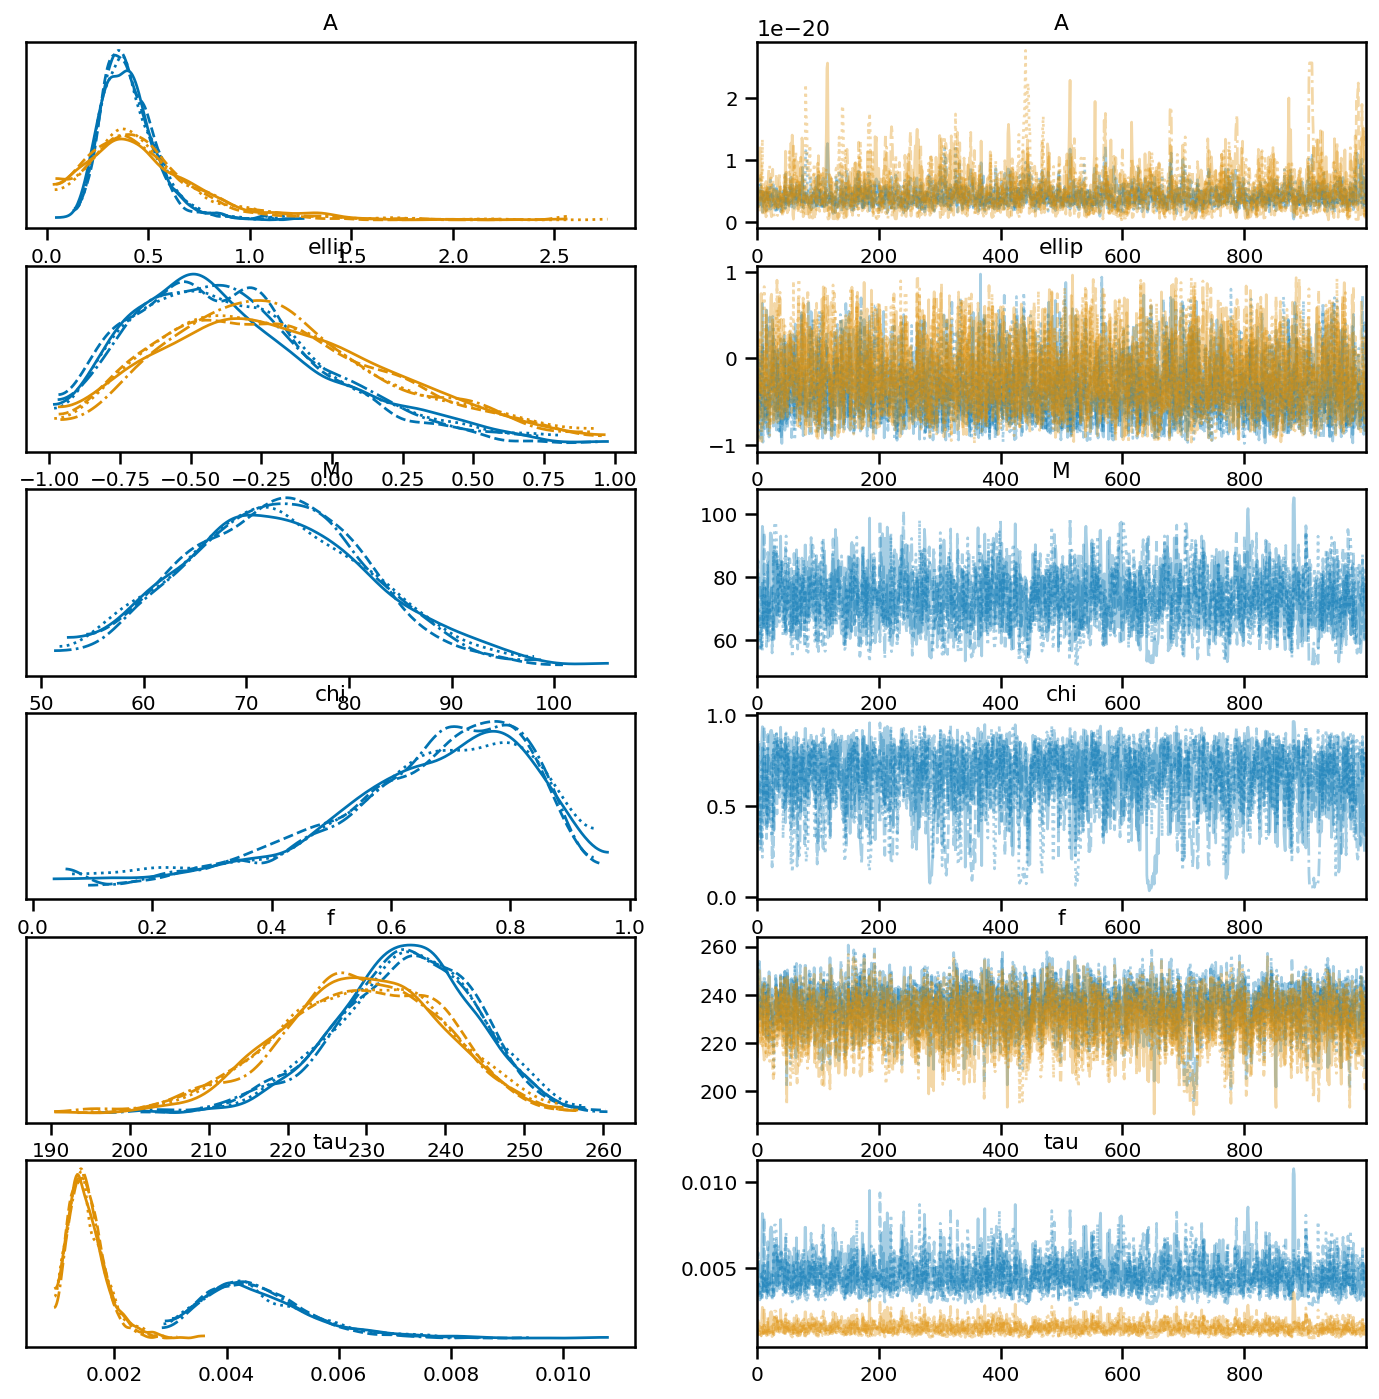

In [24]:
az.plot_trace(fit.result, var_names=['A', 'ellip', 'M', 'chi', 'f', 'tau'], compact=True);

The total mass and spin that we recover are reasonable given the full waveform analysis of GW150914 (remember that the total mass will be the *detector frame* total mass!).  Note the use of `ringdown.kdeplot_2d_clevels` which draws contours at credible levels of the KDE estimate of the posterior distribution (the default, used here, is to draw contours at the 0.1, ..., 0.9 credible levels).

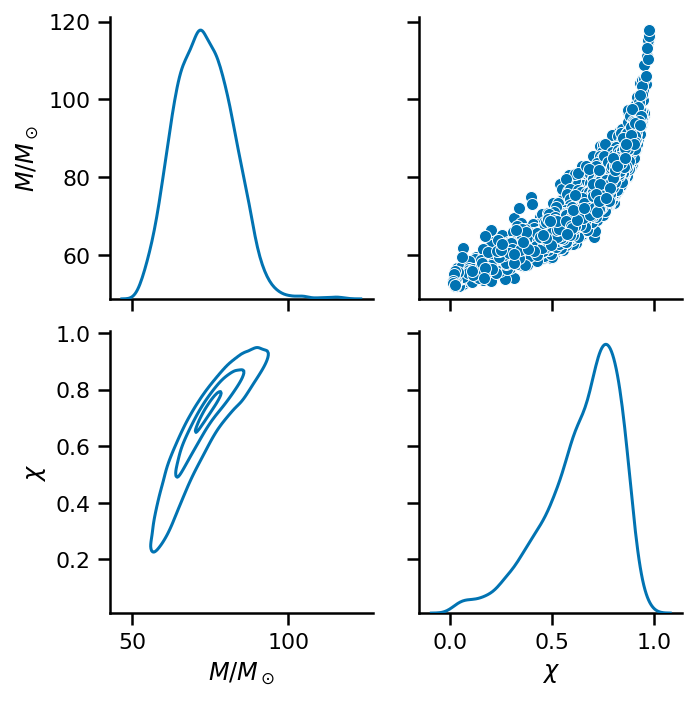

In [25]:
df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

The fundamental mode is about $240 \, \mathrm{Hz}$; we measure its frequency to ~5%.

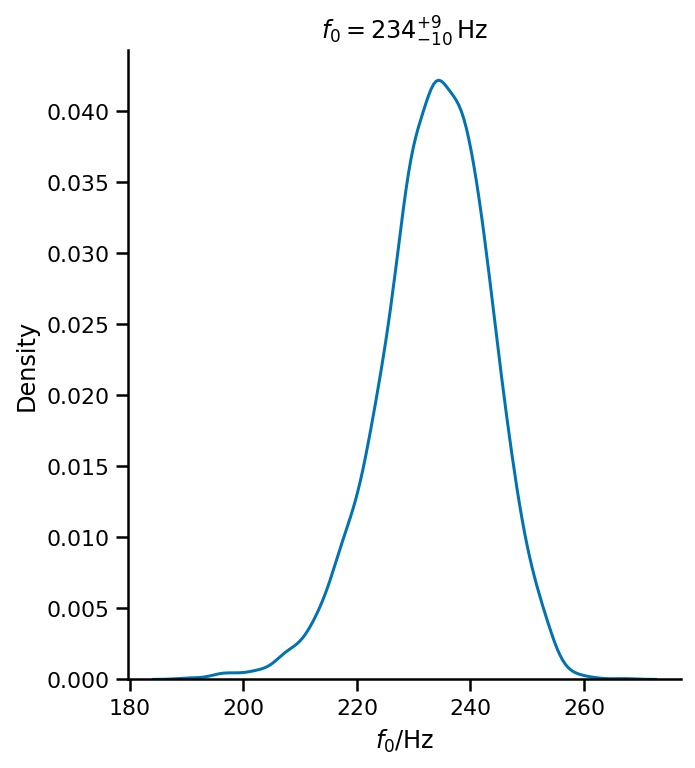

In [26]:
f0 = fit.result.posterior.f.values[:,:,0].flatten()
m = median(f0)
h = quantile(f0, 0.84)
l = quantile(f0, 0.16)
sns.displot(fit.result.posterior.f.values[:,:,0].flatten(), kind='kde')
xlabel(r'$f_0 / \mathrm{Hz}$');
title(r'$f_0 = {:.0f}^{{+{:.0f}}}_{{-{:.0f}}} \, \mathrm{{Hz}}$'.format(m, h-m, m-l));

Because of the Gaussian prior we have placed on the mode quadratures, the prior on the mode amplitudes is not flat (for small amplitude it goes as $A^3$ and then decays like a Gaussian at large amplitudes).  This is evident in the plot below.

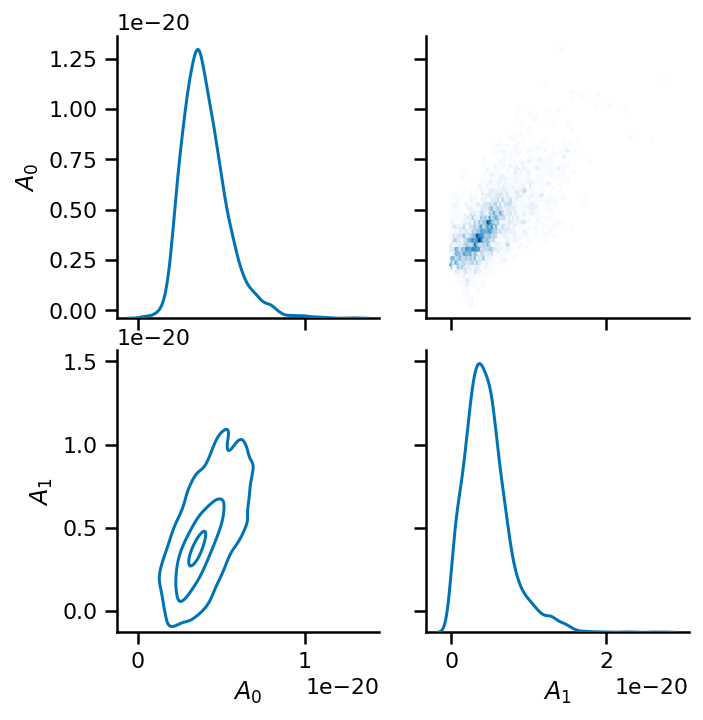

In [27]:
df = pd.DataFrame({
    r'$A_0$': fit.result.posterior.A.values[:,:,0].flatten(),
    r'$A_1$': fit.result.posterior.A.values[:,:,1].flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);
pg.axes[0,1].hexbin(df[r'$A_1$'], df[r'$A_0$'], mincnt=1, cmap="Blues")

Get mean signal reconstructions at each detector:

In [28]:
ms, mf, mo = {}, {}, {}

for i, ifo in enumerate(fit.ifos):
    
    # mean reconstructed signal at each detector
    ms[ifo] = fit.result.posterior.h_det.mean(axis=(0,1)).values[i,:] 

    # mean reconstructed fundamental mode at each detector
    mf[ifo] = fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[i,0,:]

    # mean reconstructed overtone at each detector
    mo[ifo] = fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[i,1,:]
    
for ts_dict in [ms, mf, mo]:
    for i, d in ts_dict.items():
        ts_dict[i] = ringdown.Data(d, ifo=i, index=fit.analysis_data[i].time)

Whiten the reconstructions; the `fit.whiten` accepts a dict mapping detector names to time series, and returns a dict of whitened time series. 

In [34]:
wd = fit.whiten(fit.analysis_data)
ws = fit.whiten(ms)
wf = fit.whiten(mf)
wo = fit.whiten(mo)

Compute SNRs:

In [35]:
snr_of_mean_waveform = sqrt(sum([np.dot(wd[d], ws[d])**2 / np.dot(ws[d], ws[d]) for d in fit.ifos]))
print('SNR of ringdown = {:.1f}'.format(snr_of_mean_waveform))

SNR of ringdown = 13.2


Here is a plot of the un-whitened (i.e. raw) ringdown signal, also decomposed into modes.

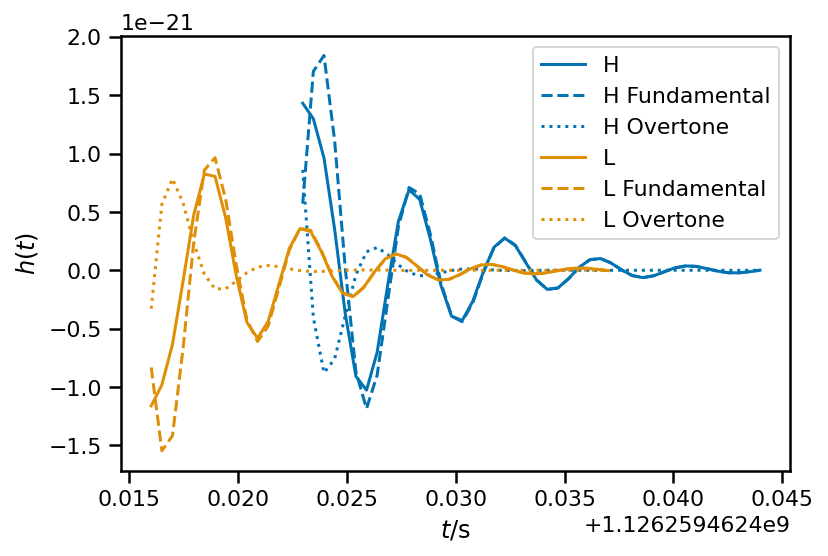

In [36]:
for ifo in fit.ifos:
    t = fit.analysis_data[ifo].time
    m = abs(t-t[0]) < 5*longest_tau
    l, = plot(t[m], ms[ifo][m], label=ifo[0])
    plot(t[m], mf[ifo][m], ls='--', color=l.get_color(), label=ifo[0]+' Fundamental')
    plot(t[m], mo[ifo][m], ls=':', color=l.get_color(), label=ifo[0]+' Overtone')

legend(loc='best');
xlabel(r'$t/\mathrm{s}$');
ylabel(r'$h(t)$');

And here are plots of the whitened signal compared to the whitened data; these can be used to visually assess the fit.

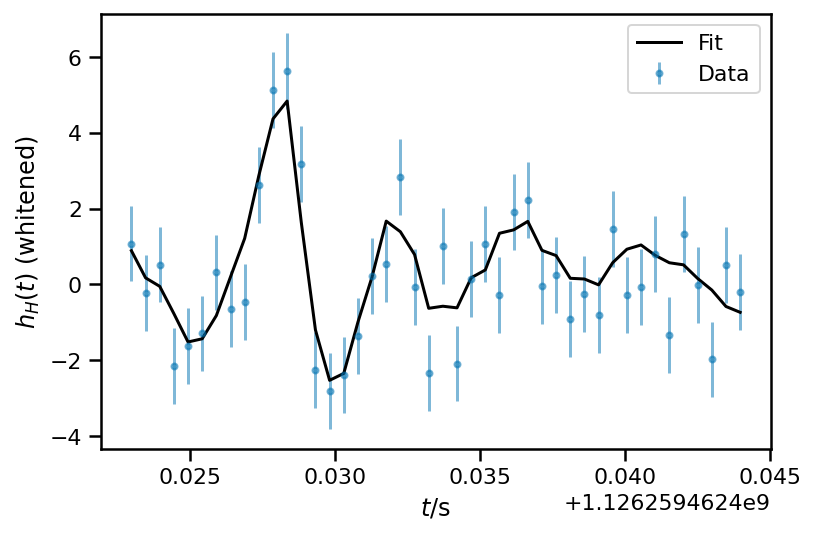

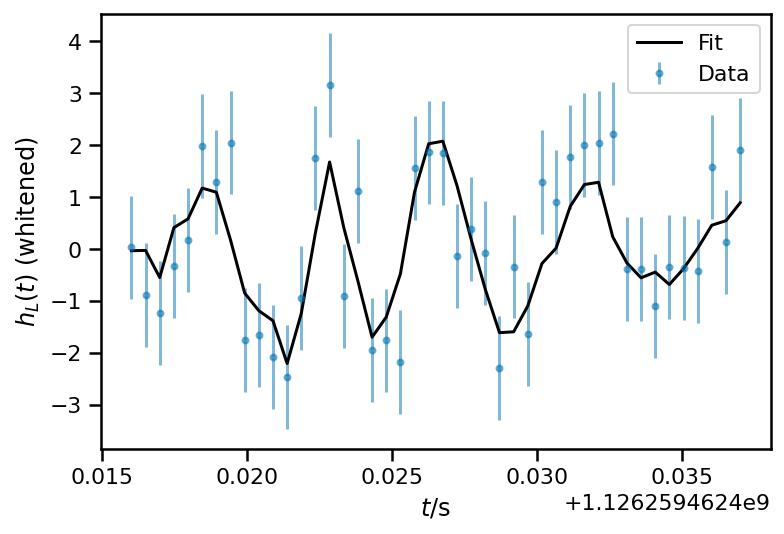

<Figure size 432x288 with 0 Axes>

In [37]:
for ifo in fit.ifos:
    t = fit.analysis_data[ifo].time
    m = abs(t-t[0]) < 5*longest_tau
    errorbar(t[m], wd[ifo][m], yerr=ones_like(wd[ifo][m]), fmt='.', 
             alpha=0.5, label='Data')
    plot(t[m], ws[ifo][m], color="black", label='Fit')

    xlabel(r'$t / \mathrm{s}$')
    ylabel(r'$h_%s(t)$ (whitened)' % ifo[0])
    legend(loc='best')
    figure()

Here is a pretty plot that combines the waveforms fitted, the whitened data versus waveforms, and the whitened residuals.  In the final panel, we plot the residuals after subtracting the mean waveform (black), the residuals after subtracting *only* the $n = 0$ mode (green), and the residuals after subtracting *only* the $n = 1$ mode (orange).

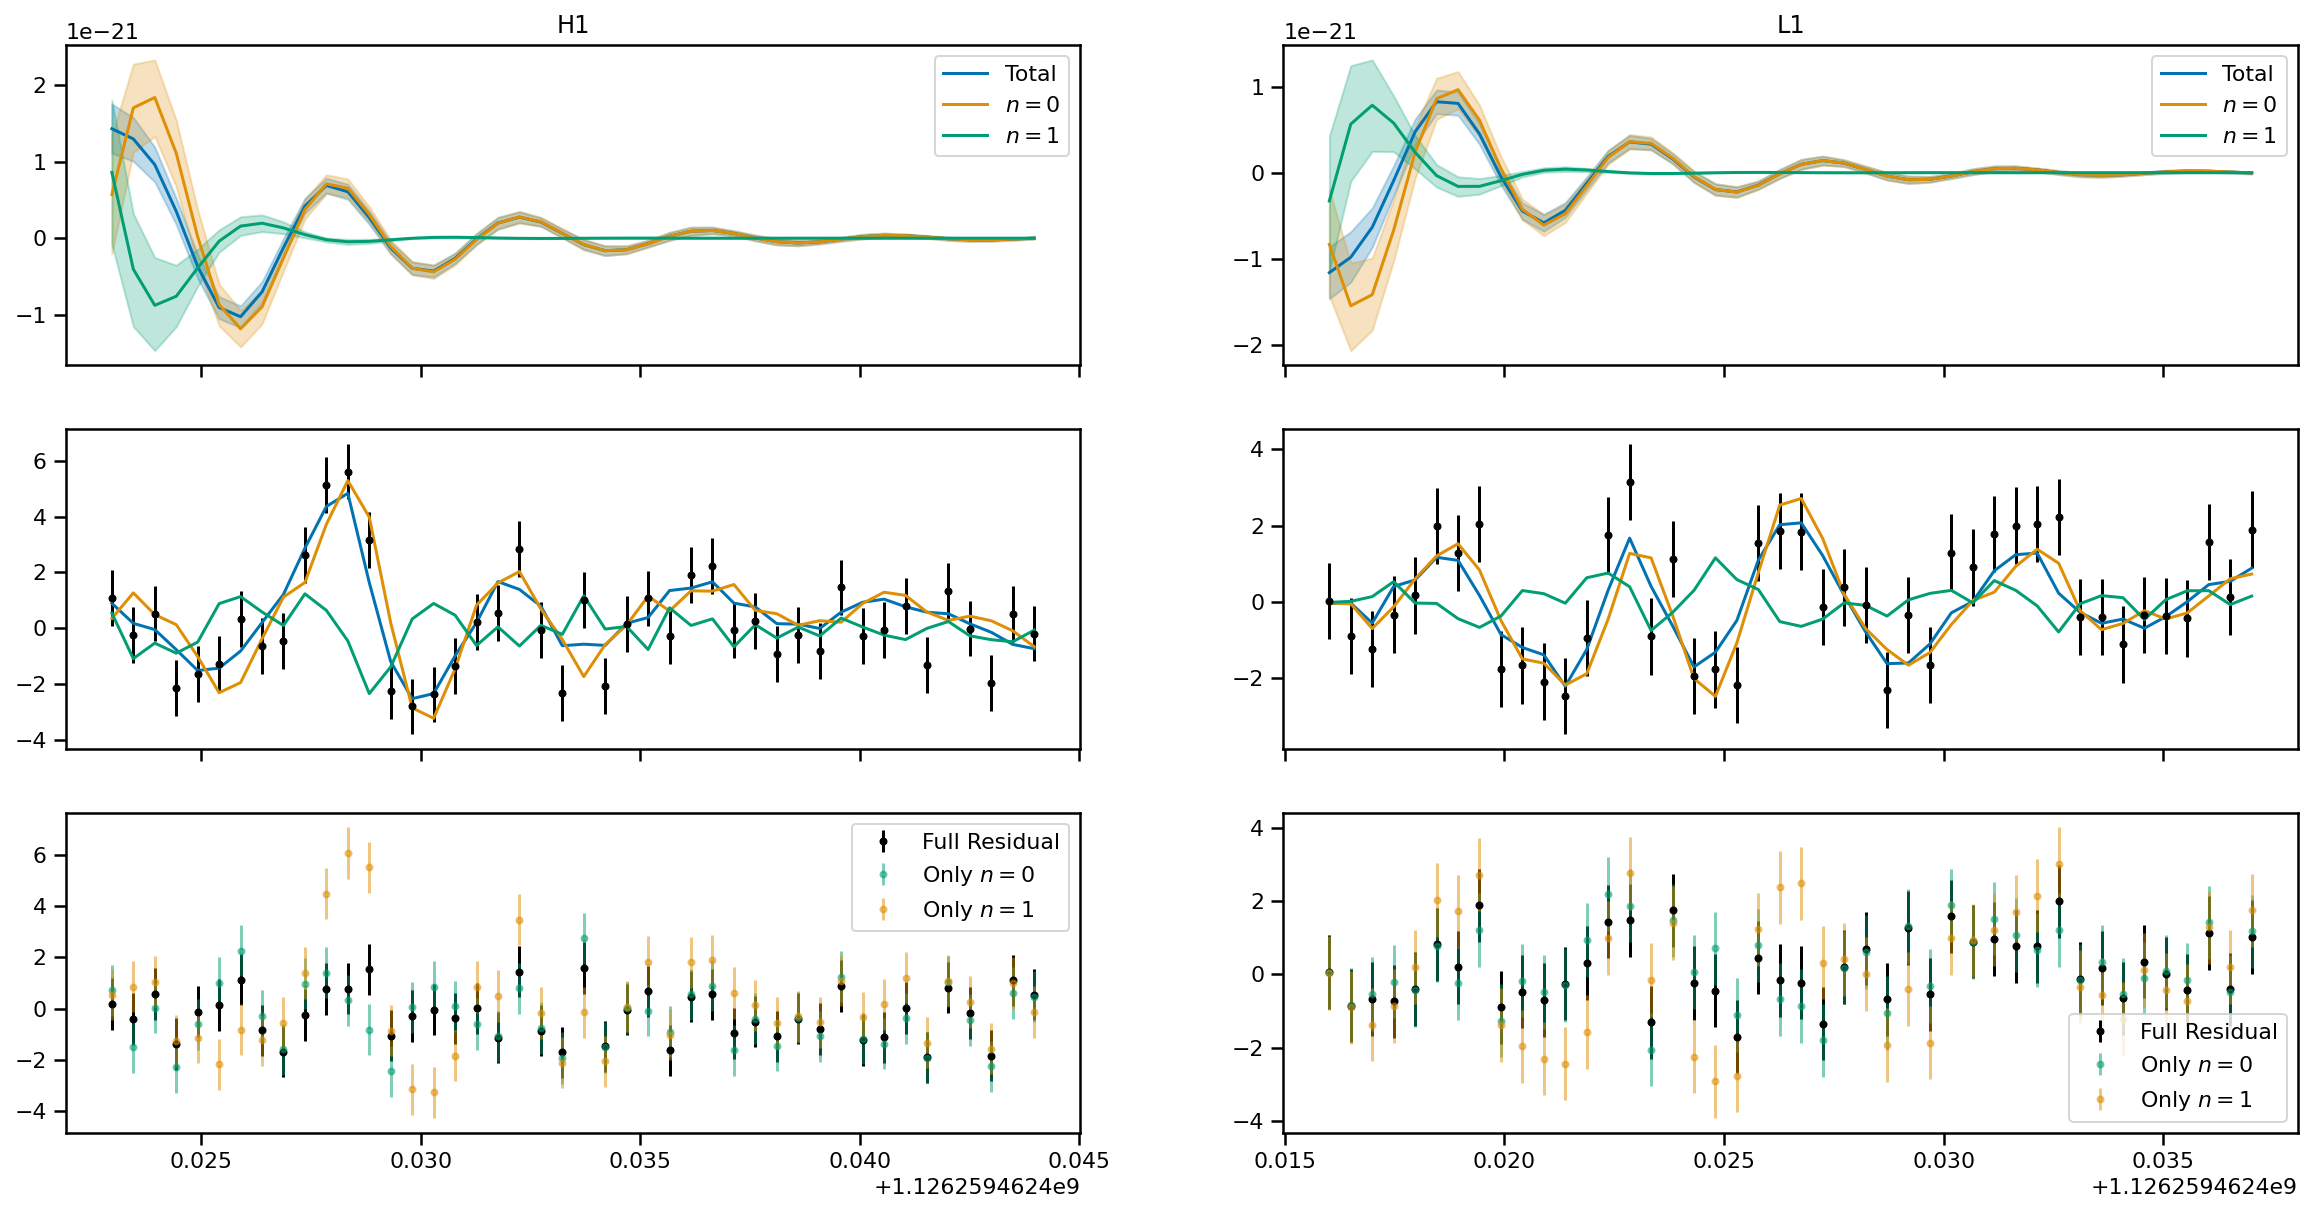

In [38]:
fig, ax = subplots(nrows=3, ncols=2, sharex='col', figsize=(20, 10))
for i, ifo in enumerate(fit.ifos):
    ax[0,i].set_title(ifo)
    t = fit.analysis_data[ifo].time
    m = abs(t - t[0]) < 5*longest_tau
    c = sns.color_palette()[0]
    ax[0,i].plot(t[m], fit.result.posterior.h_det.mean(axis=(0,1)).values[i,:][m], label=r'Total', color=c)
    ax[0,i].fill_between(t[m], quantile(fit.result.posterior.h_det.values[:,:,i,:], 0.84, axis=(0,1))[m], quantile(fit.result.posterior.h_det.values[:,:,i,:], 0.16, axis=(0,1))[m], color=c, alpha=0.25)
    for j in range(2):
        c = sns.color_palette()[j+1]
        ax[0,i].plot(t[m], fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[i,j,:][m], label=r'$n={:d}$'.format(j), color=c)
        ax[0,i].fill_between(t[m], quantile(fit.result.posterior.h_det_mode.values[:,:,i,j,:], 0.84, axis=(0,1))[m], quantile(fit.result.posterior.h_det_mode.values[:,:,i,j,:], 0.16, axis=(0,1))[m], color=c, alpha=0.25)
        ax[0,i].legend()
        
    ax[1,i].errorbar(t[m], wd[ifo][m], ones_like(t[m]), color='k', fmt='.')
    ax[1,i].plot(t[m], ws[ifo][m], color=sns.color_palette()[0])
    ax[1,i].plot(t[m], wf[ifo][m], color=sns.color_palette()[1])
    ax[1,i].plot(t[m], wo[ifo][m], color=sns.color_palette()[2])
    
    ax[2,i].errorbar(t[m], wd[ifo][m]-ws[ifo][m], ones_like(t[m]), fmt='.', color='k', label='Full Residual')
    ax[2,i].errorbar(t[m], wd[ifo][m]-wf[ifo][m], ones_like(t[m]), fmt='.', color=sns.color_palette()[2], alpha=0.5, label=r'Only $n = 0$')
    ax[2,i].errorbar(t[m], wd[ifo][m]-wo[ifo][m], ones_like(t[m]), fmt='.', color=sns.color_palette()[1], alpha=0.5, label=r'Only $n = 1$')
    ax[2,i].legend()

## Beyond-Kerr fit

We can allow for perturbations to the frequency and damping rates of subsets of the ringdown modes as a spectroscopic test of GR.  First, we copy the fit object so that we are sure to use the same data, prior settings, etc, in the GR test as we did above:

In [40]:
fit_testgr = fit.copy()

A reminder about the prior options we can set:

In [41]:
print(fit_testgr.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max', 'flat_A', 'flat_A_ellip']


To test GR, we allow for perturbations of the overtone frequency and damping time.  The parameterization used here introduces $\delta f$ and $\delta \tau$ parameters and defines 

$$
f = f_{\mathrm{GR}} e^{\delta f}
$$

and

$$
\tau = \tau_{\mathrm{GR}} e^{\delta \tau}.
$$

Thus the perturbation is defined for all values $-\infty < \delta f, \delta \tau < \infty$ and for small values of the perturbation parameter is is the *relative* deviation of the frequency/damping time from the GR value.  By default we truncate $-1/2 < \delta f, \delta \tau < 1/2$ (corresponding to a factor of $\sqrt{e} \simeq 1.6$ change away from the GR value), but this can be changed in the prior settings as well.

In [42]:
fit_testgr.update_prior(perturb_f=[0,1], perturb_tau=[0,1])
fit_testgr.prior_settings

{'A_scale': 2e-21,
 'perturb_f': [0, 1],
 'perturb_tau': [0, 1],
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A': 1,
 'flat_A_ellip': 0}

In [43]:
fit_testgr.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
/Users/wfarr/miniconda3/envs/ringdown/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/Users/wfarr/miniconda3/envs/ringdown/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
/Users/wfarr/miniconda3/env

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 142 seconds.
INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 142 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


Plot the trace (note that we don't show the `0` component of the frequency and damping time perturbations because the `0` mode is pinned to the GR frequency and damping time).

array([[<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'M'}>],
       [<AxesSubplot:title={'center':'chi'}>,
        <AxesSubplot:title={'center':'chi'}>],
       [<AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'df'}>],
       [<AxesSubplot:title={'center':'dtau'}>,
        <AxesSubplot:title={'center':'dtau'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>]], dtype=object)

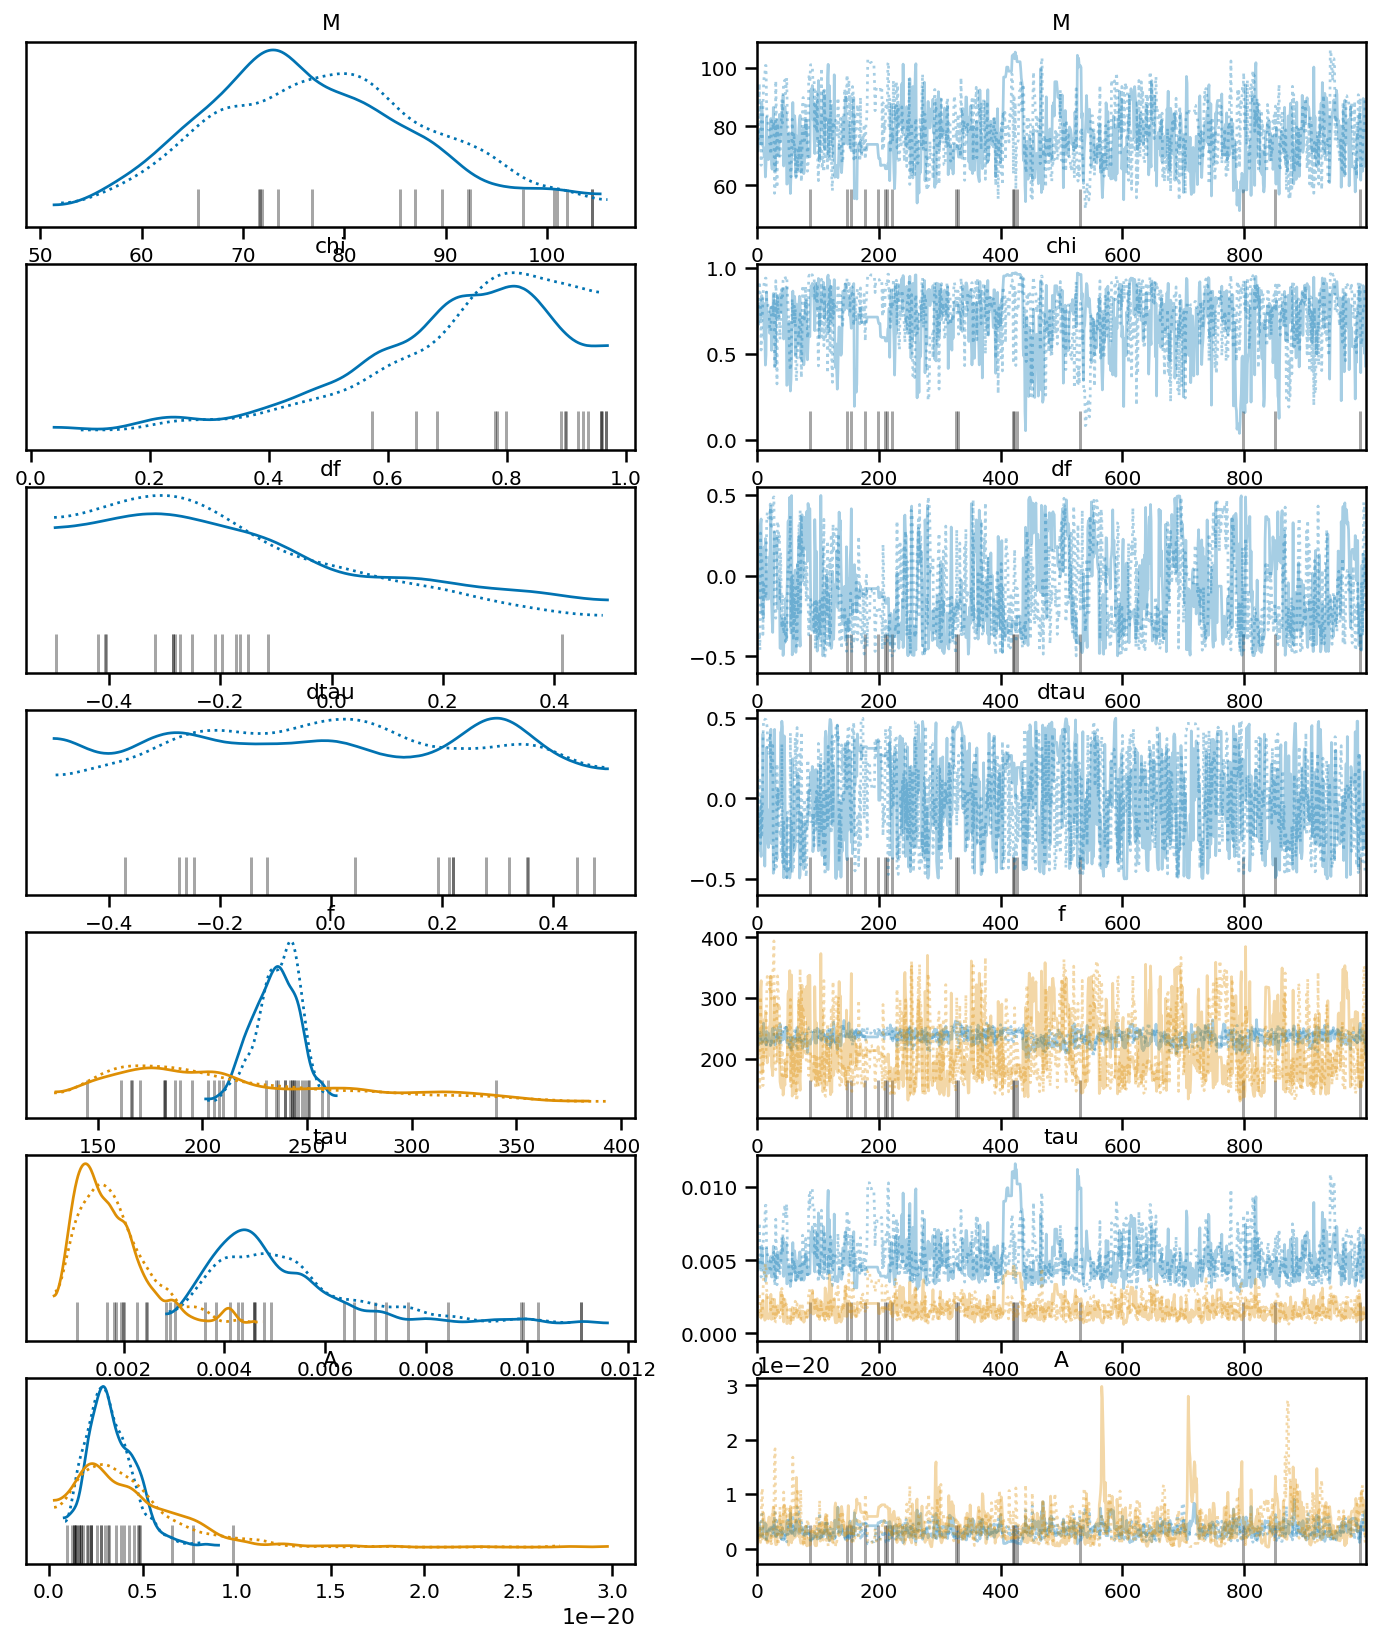

In [44]:
az.plot_trace(fit_testgr.result, var_names=['M', 'chi', 'df', 'dtau', 'f', 'tau', 'A'],
              coords={'df_dim_0': 1, 'dtau_dim_0': 1})

You can see that we place a constraint on the $\delta f$ parameter; the 1-sigma range is about 25\%, and the posterior peaks noticeably around the GR value of $\delta f = 0$.  The posterior on $\delta \tau$ is nearly flat, with a modest preference for larger $\delta \tau$, but still fully consistent with GR.  In 2D (lower left plot) the GR value of $(0,0)$ is contained within the 50% credible contour.

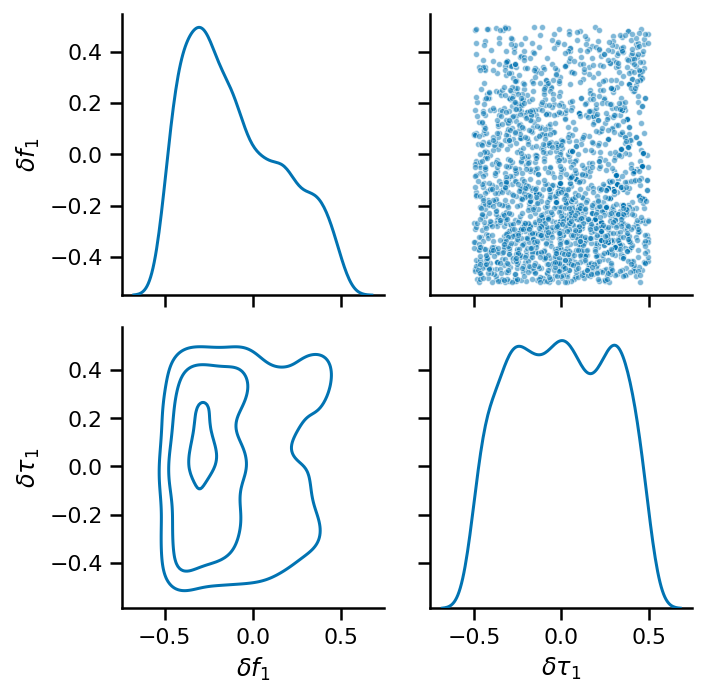

In [45]:
df = pd.DataFrame({
    r'$\delta f_1$': fit_testgr.result.posterior.df.values[:,:,1].flatten(),
    r'$\delta \tau_1$': fit_testgr.result.posterior.dtau.values[:,:,1].flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_upper(sns.scatterplot, marker='.', alpha=0.5)
pg.map_diag(sns.kdeplot)
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

In [46]:
df = fit_testgr.result.posterior.df.values[:,:,1].flatten()
print('1-sigma (68%) range of df in [{:.2f}, {:.2f}]'.format(quantile(df, 0.16), quantile(df, 0.84)))

1-sigma (68%) range of df in [-0.38, 0.21]
